In [1]:
#tensorflow versi berapa
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras, tinymlgen


In [10]:
# 1. IMPOR PUSTAKA YANG DIBUTUHKAN
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Mengatur agar pesan log TensorFlow tidak terlalu ramai
import logging
tf.get_logger().setLevel(logging.ERROR)


# 2. PERSIAPAN DIREKTORI
print("🚀 Membuat direktori untuk Kasus A...")

# Membuat folder-folder untuk menyimpan semua hasil dari Kasus A
os.makedirs("saved_models_kasus_a", exist_ok=True)
os.makedirs("tflite_models_kasus_a_float", exist_ok=True)
os.makedirs("tflite_models_kasus_a_int8", exist_ok=True)
os.makedirs("headers_kasus_a_float", exist_ok=True)
os.makedirs("headers_kasus_a_int8", exist_ok=True)

print("✅ Direktori siap.")

🚀 Membuat direktori untuk Kasus A...
✅ Direktori siap.


In [11]:
# 3. PEMBUATAN DAN PEMBAGIAN DATA SINTETIS (KASUS A)
print("🚀 Membuat data sintetis untuk fungsi y = 2x + 1...")

# Parameter untuk generasi data baru
num_points = 1000
step = 0.5

# Membuat 1000 titik data x dengan step 0.5, terpusat di 0
x_all = (np.arange(num_points) - (num_points - 1) / 2.0) * step
x_all = x_all.astype(np.float32)

# Data y tetap berdasarkan fungsi y = 2x + 1
y_all = 2 * x_all + 1

# Reshape menjadi format yang dibutuhkan Keras
x_all = x_all.reshape(-1, 1)
y_all = y_all.reshape(-1, 1)

# Mengacak data
np.random.seed(42)
indices = np.arange(x_all.shape[0])
np.random.shuffle(indices)

x_shuffled = x_all[indices]
y_shuffled = y_all[indices]

# --- PERUBAHAN DI SINI ---
# Pembagian data menjadi 800 train, 100 validation, 100 test
num_train = 800
num_val = 100

x_train = x_shuffled[:num_train]
y_train = y_shuffled[:num_train]

x_val = x_shuffled[num_train : num_train + num_val]
y_val = y_shuffled[num_train : num_train + num_val]

x_test = x_shuffled[num_train + num_val :]
y_test = y_shuffled[num_train + num_val :]
# -------------------------

print("✅ Data berhasil dibuat dan dibagi:")
print(f"   Bentuk x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"   Bentuk x_val:   {x_val.shape}, y_val:   {y_val.shape}")
print(f"   Bentuk x_test:  {x_test.shape}, y_test:  {y_test.shape}")

🚀 Membuat data sintetis untuk fungsi y = 2x + 1...
✅ Data berhasil dibuat dan dibagi:
   Bentuk x_train: (800, 1), y_train: (800, 1)
   Bentuk x_val:   (100, 1), y_val:   (100, 1)
   Bentuk x_test:  (100, 1), y_test:  (100, 1)


In [25]:
# Konfigurasi model: [(jumlah layer, neuron per layer)]
model_configs = [
    (1, 8),
    (2, 16),
    (3, 32),
    (4, 64),
]

# Definisikan EarlyStopping terlebih dahulu
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, # Berhenti setelah 20 epoch tanpa perbaikan
    restore_best_weights=True,
    verbose=0 
)

# List baru untuk menyimpan seluruh riwayat loss
all_train_loss_histories = []
all_val_loss_histories = []

# List untuk menyimpan hasil akhir
all_best_val_losses = []
all_test_losses = []
all_best_epochs = []
model_labels = []

print("\n🚀 Melatih, Mengevaluasi, dan Mengumpulkan Hasil untuk Kasus A...\n")

for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    # Bagian Training disesuaikan untuk input shape (1,) Kasus A
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(1,)))
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss='mean_squared_error'
    )
    
    history = model.fit(
        x_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Path penyimpanan disesuaikan untuk Kasus A
    model_path = f"saved_models_kasus_a/model_{idx}_layers_{num_layers}_neurons_{neurons}.keras"
    model.save(model_path)

    # --- Proses Pengumpulan Hasil Sesuai Struktur Anda ---

    # 1. Cari epoch terbaik dan kumpulkan loss-nya
    # Karena EarlyStopping me-restore bobot terbaik, kita evaluasi langsung
    best_epoch_index = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_epoch_index]
    test_loss = model.evaluate(x_test, y_test, verbose=0)
    
    # 2. Simpan riwayat loss HANYA SAMPAI epoch terbaik untuk plotting
    # Ini membuat plot loss lebih fokus pada proses pembelajaran yang relevan
    all_train_loss_histories.append(history.history['loss'][:best_epoch_index + 1])
    all_val_loss_histories.append(history.history['val_loss'][:best_epoch_index + 1])

    # 3. Simpan data ringkasan ke dalam list
    all_best_epochs.append(best_epoch_index + 1)
    all_best_val_losses.append(best_val_loss)
    all_test_losses.append(test_loss)
    model_labels.append(f"Model {idx} ({num_layers}L, {neurons}N)")
    
    # 4. Tampilkan output yang rapi selama proses berjalan
    print(f"--- Hasil untuk Model {idx} ({num_layers}L, {neurons}N) ---")
    print(f"Epoch Terbaik: {best_epoch_index + 1} | Val Loss Terbaik: {best_val_loss:.6f} | Test Loss: {test_loss:.6f}")
    print("-" * 70)

# Tampilkan ringkasan akhir yang rapi
print("\n🏁 Pengumpulan Data Selesai. Ringkasan Hasil Akhir (Kasus A):\n")
for i in range(len(model_labels)):
    print(f"{model_labels[i]}:")
    print(f"   Epoch Terbaik: {all_best_epochs[i]} | Val Loss Terbaik: {all_best_val_losses[i]:.6f} | Test Loss: {all_test_losses[i]:.6f}")


🚀 Melatih, Mengevaluasi, dan Mengumpulkan Hasil untuk Kasus A...

--- Hasil untuk Model 1 (1L, 8N) ---
Epoch Terbaik: 200 | Val Loss Terbaik: 0.656656 | Test Loss: 0.866483
----------------------------------------------------------------------
--- Hasil untuk Model 2 (2L, 16N) ---
Epoch Terbaik: 200 | Val Loss Terbaik: 0.004063 | Test Loss: 0.002223
----------------------------------------------------------------------
--- Hasil untuk Model 3 (3L, 32N) ---
Epoch Terbaik: 164 | Val Loss Terbaik: 0.000177 | Test Loss: 0.000235
----------------------------------------------------------------------
--- Hasil untuk Model 4 (4L, 64N) ---
Epoch Terbaik: 133 | Val Loss Terbaik: 0.000376 | Test Loss: 0.000617
----------------------------------------------------------------------

🏁 Pengumpulan Data Selesai. Ringkasan Hasil Akhir (Kasus A):

Model 1 (1L, 8N):
   Epoch Terbaik: 200 | Val Loss Terbaik: 0.656656 | Test Loss: 0.866483
Model 2 (2L, 16N):
   Epoch Terbaik: 200 | Val Loss Terbaik: 0.0


📊 Membuat visualisasi hasil pelatihan (versi diperbaiki)...



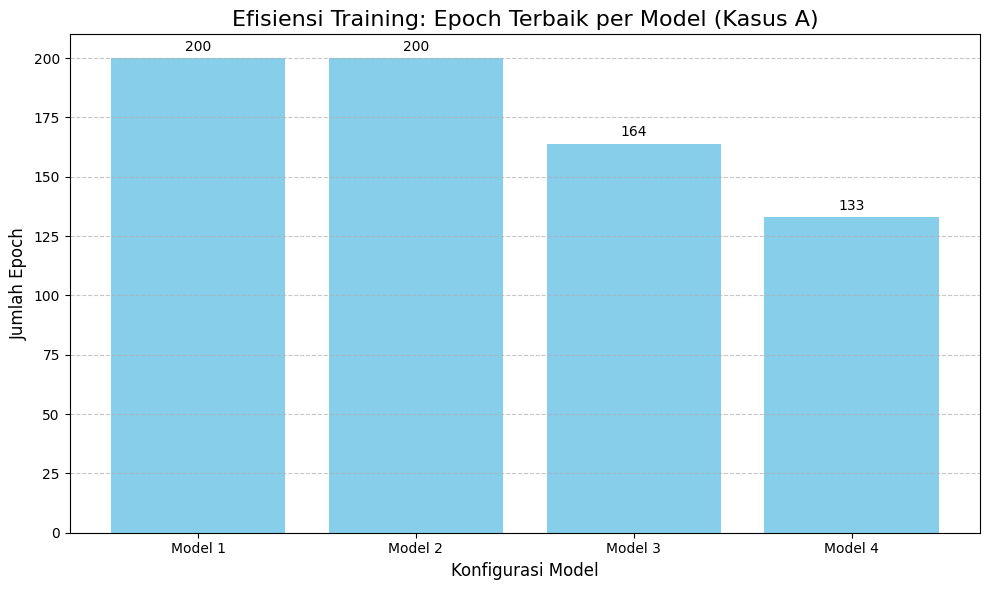

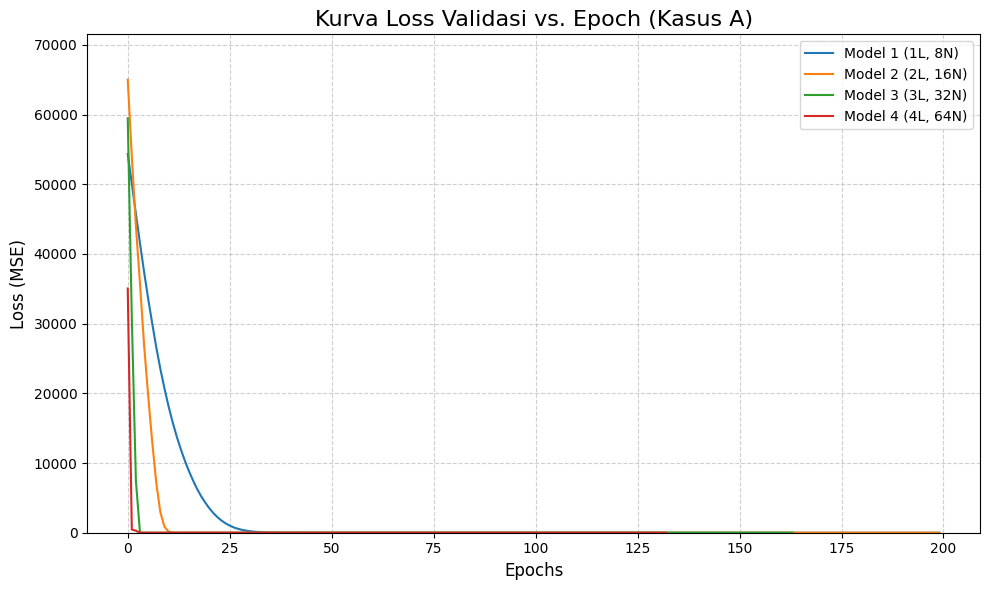

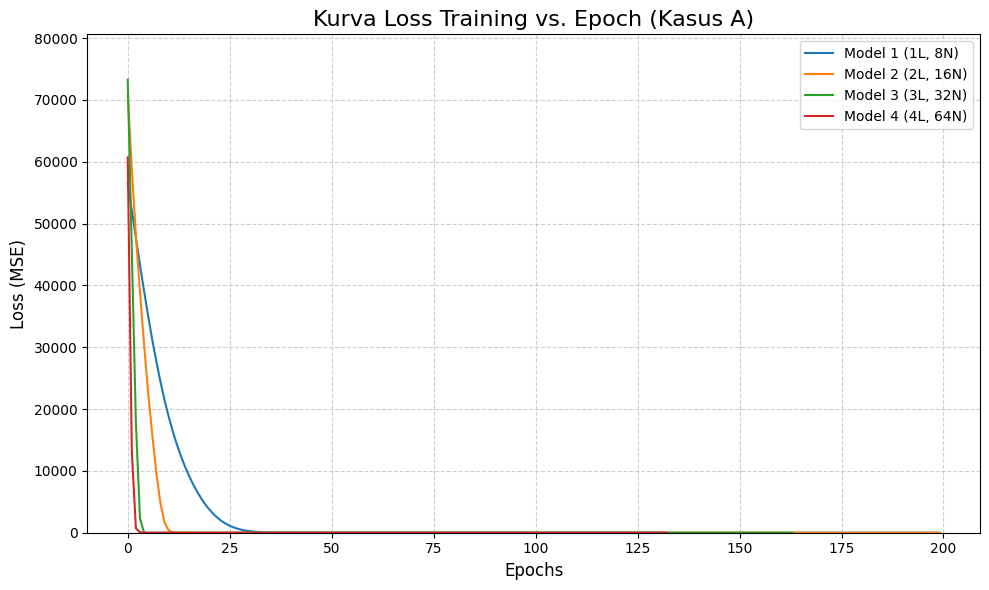

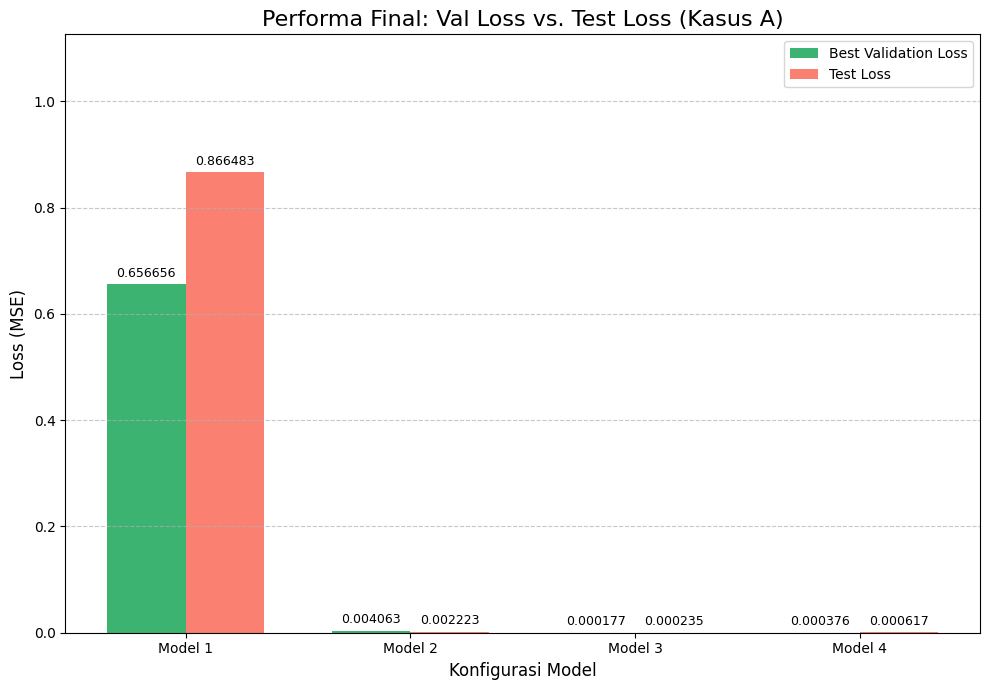

In [26]:
# Bagian ini dijalankan setelah Bagian 3 (Training) selesai

print("\n📊 Membuat visualisasi hasil pelatihan (versi diperbaiki)...\n")

# Buat label yang lebih deskriptif untuk sumbu-x
short_labels = [f'Model {i+1}' for i in range(len(model_configs))]
# Menggunakan model_labels dari Bagian 3 untuk legenda plot kurva
# model_labels = [f'Model {idx}\n({num_layers}L, {neurons}N)']

# ================================================================
# Plot 1: Grafik Batang Epoch Terbaik
# ================================================================
plt.figure(figsize=(10, 6))
bars_epoch = plt.bar(short_labels, all_best_epochs, color='skyblue')
plt.title('Efisiensi Training: Epoch Terbaik per Model (Kasus A)', fontsize=16)
plt.ylabel('Jumlah Epoch', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar_label(bars_epoch, padding=3)
plt.tight_layout()
plt.show()


# ================================================================
# Plot 2: Kurva Validation Loss vs. Epoch
# ================================================================
plt.figure(figsize=(10, 6))
for i, val_loss_history in enumerate(all_val_loss_histories):
    plt.plot(val_loss_history, label=model_labels[i].replace('\n', ' '))
plt.title('Kurva Loss Validasi vs. Epoch (Kasus A)', fontsize=16)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
# Perbaikan: Mengatur batas Y berdasarkan nilai maksimum dari semua riwayat loss validasi
max_y_val = max([max(h) for h in all_val_loss_histories if h])
plt.ylim(0, max_y_val * 1.1) 
plt.tight_layout()
plt.show()


# ================================================================
# Plot 3: Kurva Training Loss vs. Epoch
# ================================================================
plt.figure(figsize=(10, 6))
for i, train_loss_history in enumerate(all_train_loss_histories):
    plt.plot(train_loss_history, label=model_labels[i].replace('\n', ' '))
plt.title('Kurva Loss Training vs. Epoch (Kasus A)', fontsize=16)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
# Perbaikan: Mengatur batas Y berdasarkan nilai maksimum dari semua riwayat loss training
max_y_train = max([max(h) for h in all_train_loss_histories if h])
plt.ylim(0, max_y_train * 1.1)
plt.tight_layout()
plt.show()


# ================================================================
# Plot 4: Grafik Batang Test Loss vs. Val Loss
# ================================================================
plt.figure(figsize=(10, 7))
x_pos = np.arange(len(short_labels))
width = 0.35

rects1 = plt.bar(x_pos - width/2, all_best_val_losses, width, label='Best Validation Loss', color='mediumseagreen')
rects2 = plt.bar(x_pos + width/2, all_test_losses, width, label='Test Loss', color='salmon')

plt.title('Performa Final: Val Loss vs. Test Loss (Kasus A)', fontsize=16)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend()
plt.bar_label(rects1, padding=3, fmt='%.6f', fontsize=9)
plt.bar_label(rects2, padding=3, fmt='%.6f', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
max_loss_final = max(max(all_best_val_losses), max(all_test_losses))
if max_loss_final > 0:
    plt.ylim(0, max_loss_final * 1.3)
plt.tight_layout()
plt.show()

In [27]:
# Bagian ini dijalankan setelah Bagian 2 (Persiapan Data) selesai

print("\n🚀 Mengekspor keseluruhan data uji ke format C array (.h)...")

#=============================================================================
# Konfigurasi Ekspor
#=============================================================================
# Nama file header yang akan dibuat
output_header_path = 'test_data_kasus_a.h'

# Mengambil seluruh data uji
x_test_to_export = x_test
y_test_to_export = y_test

# Mendapatkan parameter secara dinamis dari data
num_test_samples = len(x_test_to_export)
num_features = x_test_to_export.shape[1]

#=============================================================================
# Fungsi untuk memformat array NumPy menjadi string C
#=============================================================================
def format_array_to_c(array, var_name, var_type='float'):
    c_string = f"const {var_type} {var_name}[] = {{"
    flat_array = array.flatten()
    # Format angka dengan presisi untuk float, atau sebagai integer
    formatted_values = [f"{val:.8f}f" if var_type == 'float' else str(int(val)) for val in flat_array]
    c_string += ", ".join(formatted_values)
    c_string += "};"
    return c_string

#=============================================================================
# Proses Pembuatan File Header
#=============================================================================
# Format array fitur (x_test) menjadi string C
c_features_array = format_array_to_c(x_test_to_export, "test_features_a", "float")

# Format array label (y_test) menjadi string C
c_labels_array = format_array_to_c(y_test_to_export, "test_labels_a", "float")

# Gabungkan semua menjadi satu file header
header_content = f"""
// File ini berisi {num_test_samples} sampel data uji untuk Kasus A (y = 2x + 1)
// Digunakan untuk validasi dan pengujian performa pada perangkat keras
#ifndef TEST_DATA_KASUS_A_H
#define TEST_DATA_KASUS_A_H

const int TEST_SAMPLES_COUNT_A = {num_test_samples};
const int FEATURES_PER_SAMPLE_A = {num_features};

// Data Fitur Uji (diratakan menjadi array 1D)
{c_features_array}

// Data Label Sebenarnya (Ground Truth)
{c_labels_array}

#endif // TEST_DATA_KASUS_A_H
"""

# Tulis ke file .h
with open(output_header_path, 'w') as f:
    f.write(header_content)

print(f"✅ Data uji berhasil diekspor ke file C header: '{output_header_path}'")
print(f"   File tersebut berisi seluruh {num_test_samples} sampel data uji.")


🚀 Mengekspor keseluruhan data uji ke format C array (.h)...
✅ Data uji berhasil diekspor ke file C header: 'test_data_kasus_a.h'
   File tersebut berisi seluruh 100 sampel data uji.


In [28]:
# Bagian ini dijalankan setelah Bagian 2 (Persiapan Data)

print("🚀 Membuat fungsi untuk representative dataset (versi disempurnakan)...")

def representative_dataset_generator():
    """
    Generator yang menghasilkan sampel representatif untuk kalibrasi kuantisasi.
    Memastikan nilai ekstrem (min/max) disertakan bersama sampel acak.
    """
    # 1. Tentukan jumlah total sampel untuk kalibrasi (100-300 adalah umum)
    num_samples = 200

    # 2. Ambil nilai ekstrem dari rentang data asli kita.
    # Nilai ini didasarkan pada pembuatan data di Bagian 2.
    min_val = np.array([[-249.75]], dtype=np.float32)
    max_val = np.array([[249.75]], dtype=np.float32)

    # 3. Ambil sisa sampel secara acak dari data latih (x_train).
    # Kita butuh `num_samples - 2` sampel acak.
    num_random_samples = num_samples - 2
    
    # Ambil indeks acak dari x_train tanpa duplikasi.
    random_indices = np.random.choice(
        np.arange(len(x_train)), 
        size=num_random_samples, 
        replace=False
    )
    random_samples = x_train[random_indices]

    # 4. Gabungkan nilai ekstrem dengan sampel acak.
    combined_dataset = np.vstack([min_val, max_val, random_samples])

    # 5. Acak kembali gabungan dataset agar urutannya tidak bisa ditebak.
    np.random.shuffle(combined_dataset)

    # 6. Gunakan 'yield' untuk memberikan satu per satu data.
    # TFLite Converter akan memanggil generator ini berulang kali.
    for data in combined_dataset:
        # Data harus dalam bentuk list dari tensor dengan batch size 1.
        # Jika model input shape adalah (1,), maka data harus (1, 1).
        yield [data.reshape(1, 1)]

print("✅ Fungsi 'representative_dataset_generator' yang disempurnakan berhasil dibuat.")

🚀 Membuat fungsi untuk representative dataset (versi disempurnakan)...
✅ Fungsi 'representative_dataset_generator' yang disempurnakan berhasil dibuat.


In [29]:
# Bagian ini dijalankan setelah Bagian 3 (Training) dan Bagian 6 (Generator)

print("\n🚀 Memulai proses konversi model ke format .tflite (Float32 & INT8)...")

# Loop melalui setiap konfigurasi model yang telah kita latih
for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    print(f"--- Mengonversi Model {idx} ({num_layers}L, {neurons}N) ---")
    
    # Path ke model Keras yang sudah disimpan
    keras_model_path = f"saved_models_kasus_a/model_{idx}_layers_{num_layers}_neurons_{neurons}.keras"
    model = tf.keras.models.load_model(keras_model_path)
    
    # --- Konversi ke TFLite Float32 (Standar) ---
    converter_float = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model_float = converter_float.convert()
    
    # Simpan file .tflite Float32
    tflite_path_float = f"tflite_models_kasus_a_float/model_a_{idx}_float.tflite"
    with open(tflite_path_float, "wb") as f:
        f.write(tflite_model_float)
    print(f"  ✅ Model Float32 disimpan di: {tflite_path_float}")

    # --- Konversi ke TFLite INT8 (Full Integer Quantization) ---
    converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_int8.representative_dataset = representative_dataset_generator
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_int8.inference_input_type = tf.int8
    converter_int8.inference_output_type = tf.int8
    converter_int8._experimental_disable_per_channel_quantization_for_dense_layers = True
    
    tflite_model_int8 = converter_int8.convert()
    
    # Simpan file .tflite INT8
    tflite_path_int8 = f"tflite_models_kasus_a_int8/model_a_{idx}_int8.tflite"
    with open(tflite_path_int8, "wb") as f:
        f.write(tflite_model_int8)
    print(f"  ✅ Model INT8 disimpan di: {tflite_path_int8}\n")

print("\n🏁 Semua model berhasil dikonversi ke format .tflite.")


🚀 Memulai proses konversi model ke format .tflite (Float32 & INT8)...
--- Mengonversi Model 1 (1L, 8N) ---
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmp0p92sxvm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_27')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1378192402256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378192402640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378192402832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378192400144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  ✅ Model Float32 disimpan di: tflite_models_kasus_a_float/model_a_1_float.tflite
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpshcrx5lx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_27')
Output Typ

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmp1byzf4w2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_28')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1378318052688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378318051344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1377892216528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1377892214224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1377892213840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1377892216336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  ✅ Model Float32 disimpan di: tflite_models_kasus_a_float/model_a_2_float.tflite
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpp7fdnznl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name=

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpt5cg0s5k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_29')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1378345719120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378345723728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378345723536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378345722960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378345722768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378345722192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378345722000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378345724304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  ✅ Model Float32 disimpan di: tflite_models_kasus_a_float/model_a_3_float.tflite
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpbb6w9bsu'. Th

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmprmyvnfwa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_30')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1378346771920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346770768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346770576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346770000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346769808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346766544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346767504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346772496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346772688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378346773264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  ✅ Model Float

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [32]:
# Bagian ini dijalankan setelah Bagian 7 (Konversi Model) selesai

print("\n🚀 Mengekstrak informasi kuantisasi dari setiap model INT8...\n")

# Loop melalui setiap model yang telah dikonversi ke INT8
for idx in range(1, len(model_configs) + 1):
    # Path disesuaikan untuk Kasus A
    quant_path = f"tflite_models_kasus_a_int8/model_a_{idx}_int8.tflite"
    
    # Buat interpreter untuk membaca model
    interpreter = tf.lite.Interpreter(model_path=quant_path)
    interpreter.allocate_tensors()

    # Dapatkan detail dari tensor input dan output
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Cetak informasi kuantisasinya
    print("="*50)
    print(f"📦 Info Kuantisasi untuk Model {idx} (Kasus A)")
    print("="*50)
    print(f"🔹 Input scale      : {input_details['quantization'][0]}")
    print(f"🔹 Input zero point : {input_details['quantization'][1]}")
    print(f"🔹 Output scale     : {output_details['quantization'][0]}")
    print(f"🔹 Output zero point: {output_details['quantization'][1]}\n")

print("\n🏁 Ekstraksi Informasi Selesai.\n")


🚀 Mengekstrak informasi kuantisasi dari setiap model INT8...

📦 Info Kuantisasi untuk Model 1 (Kasus A)
🔹 Input scale      : 1.958823561668396
🔹 Input zero point : -1
🔹 Output scale     : 3.9135258197784424
🔹 Output zero point: -1

📦 Info Kuantisasi untuk Model 2 (Kasus A)
🔹 Input scale      : 1.958823561668396
🔹 Input zero point : -1
🔹 Output scale     : 3.9178669452667236
🔹 Output zero point: -1

📦 Info Kuantisasi untuk Model 3 (Kasus A)
🔹 Input scale      : 1.958823561668396
🔹 Input zero point : -1
🔹 Output scale     : 3.9175753593444824
🔹 Output zero point: -1

📦 Info Kuantisasi untuk Model 4 (Kasus A)
🔹 Input scale      : 1.958823561668396
🔹 Input zero point : -1
🔹 Output scale     : 3.9176385402679443
🔹 Output zero point: -1


🏁 Ekstraksi Informasi Selesai.




🚀 Memulai pembuatan header dan pengumpulan data ukuran model...

✅ Header FLOAT dibuat: headers_kasus_a_float/model_a_1_float.h (1.58 KB)
✅ Header INT8 dibuat: headers_kasus_a_int8/model_a_1_int8.h (1.80 KB)
✅ Header FLOAT dibuat: headers_kasus_a_float/model_a_2_float.h (3.11 KB)
✅ Header INT8 dibuat: headers_kasus_a_int8/model_a_2_int8.h (2.66 KB)
✅ Header FLOAT dibuat: headers_kasus_a_float/model_a_3_float.h (10.93 KB)
✅ Header INT8 dibuat: headers_kasus_a_int8/model_a_3_int8.h (5.17 KB)
✅ Header FLOAT dibuat: headers_kasus_a_float/model_a_4_float.h (52.12 KB)
✅ Header INT8 dibuat: headers_kasus_a_int8/model_a_4_int8.h (16.35 KB)

📊 Membuat plot perbandingan ukuran model...


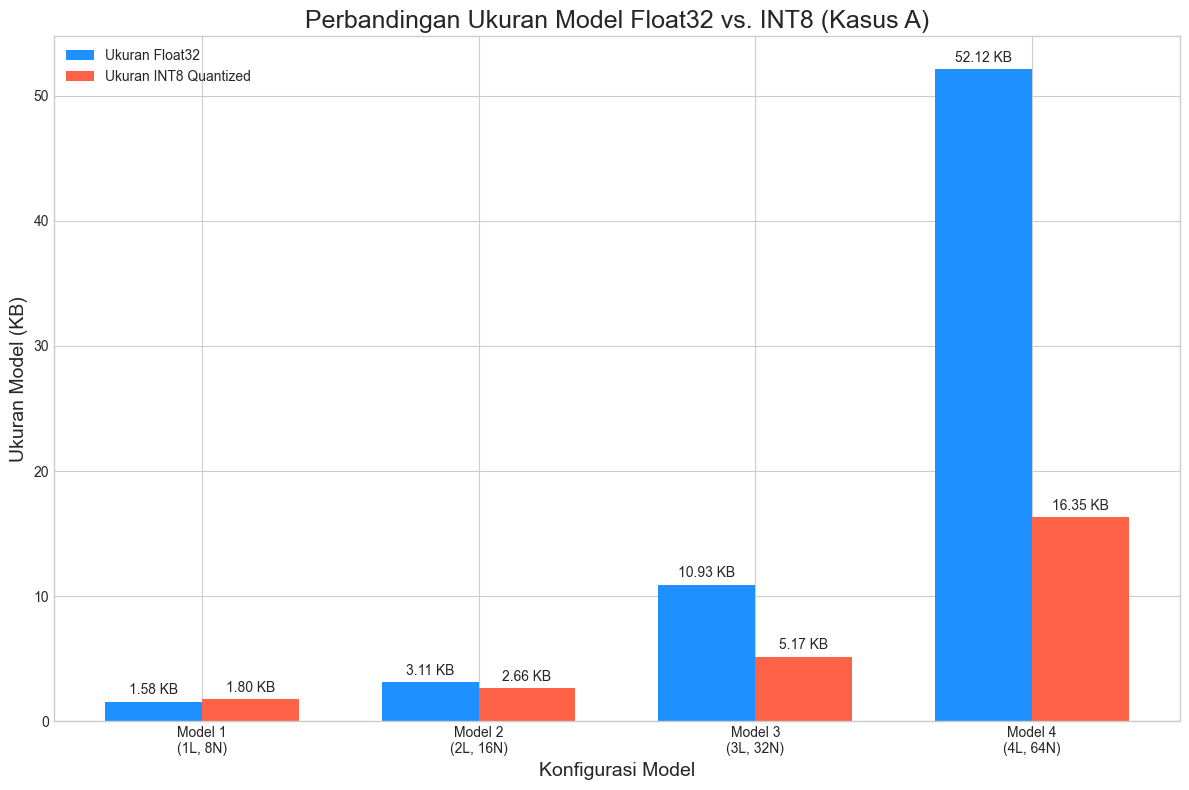


🏁 Alur kerja selesai.


In [31]:
# Bagian ini dijalankan setelah Bagian 7 (Konversi Model) selesai

# 9.1 FUNGSI UNTUK KONVERSI KE HEADER C++
def convert_to_header(tflite_model, filename, model_name, description=""):
    hex_array = ','.join(f'0x{b:02x}' for b in tflite_model)
    c_var_name = f"g_{model_name.lower().replace(' ', '_').replace('-', '_')}"
    header = f'''// File ini dibuat secara otomatis
#ifndef {c_var_name.upper()}_H
#define {c_var_name.upper()}_H

// Model: {model_name}
// {description}
// Size: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)
const unsigned char {c_var_name}_model_data[] = {{{hex_array}}};
const unsigned int {c_var_name}_model_data_len = {len(tflite_model)};

#endif // {c_var_name.upper()}_H
'''
    with open(filename, 'w') as f:
        f.write(header)

# --- PERBAIKAN DI SINI: Inisialisasi list khusus untuk plot ---
model_labels_plot = []
float_sizes = []
int8_sizes = []

print("\n🚀 Memulai pembuatan header dan pengumpulan data ukuran model...\n")

# 9.2 Loop utama untuk membuat header dan mengumpulkan ukuran
for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    
    # --- PERBAIKAN DI SINI: Buat label untuk plot di dalam loop ---
    label = f"Model {idx}\n({num_layers}L, {neurons}N)"
    model_labels_plot.append(label)

    # --- PROSES FLOAT MODEL ---
    float_path = f"tflite_models_kasus_a_float/model_a_{idx}_float.tflite"
    float_out = f"headers_kasus_a_float/model_a_{idx}_float.h"
    model_name_f = f"Kasus A Model {idx} Float"
    desc_f = f"{num_layers}L, {neurons}N, float32"
    with open(float_path, "rb") as f:
        tflite_model_float = f.read()
    convert_to_header(tflite_model_float, float_out, model_name_f, desc_f)
    float_size_kb = len(tflite_model_float) / 1024
    float_sizes.append(float_size_kb)
    print(f"✅ Header FLOAT dibuat: {float_out} ({float_size_kb:.2f} KB)")

    # --- PROSES INT8 MODEL ---
    int8_path = f"tflite_models_kasus_a_int8/model_a_{idx}_int8.tflite"
    int8_out = f"headers_kasus_a_int8/model_a_{idx}_int8.h"
    model_name_q = f"Kasus A Model {idx} INT8"
    desc_q = f"{num_layers}L, {neurons}N, int8 quantized"
    with open(int8_path, "rb") as f:
        tflite_model_int8 = f.read()
    convert_to_header(tflite_model_int8, int8_out, model_name_q, desc_q)
    int8_size_kb = len(tflite_model_int8) / 1024
    int8_sizes.append(int8_size_kb)
    print(f"✅ Header INT8 dibuat: {int8_out} ({int8_size_kb:.2f} KB)")

# 9.3 Membuat plot perbandingan ukuran setelah loop selesai
print("\n📊 Membuat plot perbandingan ukuran model...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

x = np.arange(len(model_labels_plot))
width = 0.35

rects1 = plt.bar(x - width/2, float_sizes, width, label='Ukuran Float32', color='dodgerblue')
rects2 = plt.bar(x + width/2, int8_sizes, width, label='Ukuran INT8 Quantized', color='tomato')

plt.title('Perbandingan Ukuran Model Float32 vs. INT8 (Kasus A)', fontsize=18)
plt.ylabel('Ukuran Model (KB)', fontsize=14)
plt.xlabel('Konfigurasi Model', fontsize=14)
# --- PERBAIKAN DI SINI: Menggunakan label yang baru dibuat ---
plt.xticks(x, model_labels_plot)
plt.legend()

plt.bar_label(rects1, padding=3, fmt='%.2f KB')
plt.bar_label(rects2, padding=3, fmt='%.2f KB')

plt.tight_layout()
plt.show()

print("\n🏁 Alur kerja selesai.")